In [12]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt

In [13]:
def option_chains(ticker):
    asset = yf.Ticker(ticker)
    expirations = asset.options
    
    chains = pd.DataFrame()
    
    for expiration in expirations:
        # tuple of two dataframes
        opt = asset.option_chain(expiration)
        
        calls = opt.calls
        
        calls['expiration'] = pd.to_datetime(expiration) + pd.DateOffset(hours=23, minutes=59, seconds=59)
        
        chains = pd.concat([chains, calls])
    
    chains["daysToExpiration"] = (chains.expiration - dt.datetime.today()).dt.days + 1
    
    return chains

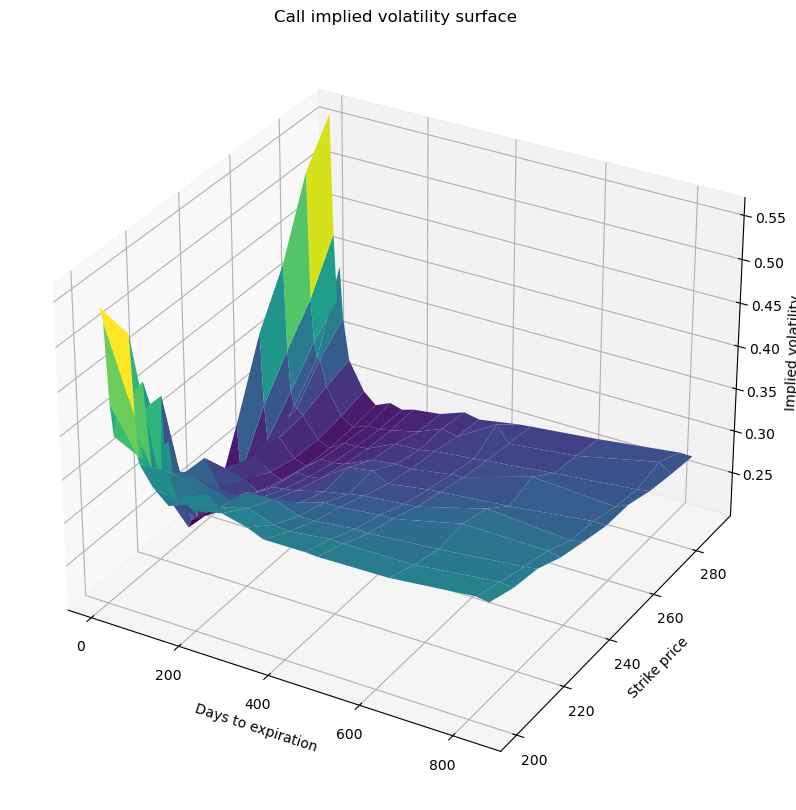

In [20]:
Ticker = "AAPL"

calls = option_chains(Ticker)
# remove high IVs
upper_bound = calls['impliedVolatility'].quantile(0.75)
calls = calls[(calls['impliedVolatility'] <= upper_bound)]

# pivot the dataframe
surface = (
    calls[['daysToExpiration', 'strike', 'impliedVolatility']]
    .pivot_table(values='impliedVolatility', index='strike', columns='daysToExpiration')
    .dropna()
)

# create the figure object
fig = plt.figure(figsize=(10, 10))

# add the subplot with projection argument
ax = fig.add_subplot(111, projection='3d')

# get the 1d values from the pivoted dataframe
x, y, z = surface.columns.values, surface.index.values, surface.values

# return coordinate matrices from coordinate vectors
X, Y = np.meshgrid(x, y)

# set labels
ax.set_xlabel('Days to expiration')
ax.set_ylabel('Strike price')
ax.set_zlabel('Implied volatility')
ax.set_title('Call implied volatility surface')

ax.plot_surface(X, Y, z, cmap='viridis')
plt.show()

In [21]:
# Convert implied volatility to total variance w = sigma^2 * T
calls = calls[calls['impliedVolatility'] > 0.01]  # Remove zero IVs
calls['totalVariance'] = (calls['impliedVolatility'] ** 2) * (calls['daysToExpiration'] / 365)  # Convert days to years


In [22]:
# SVI model function
def svi_total_variance(params, K):
    a, b, rho, m, sigma = params
    return a + b * (rho * (K - m) + np.sqrt((K - m)**2 + sigma**2))

# Objective function to minimize
def objective_function(params, strikes, market_total_variance):
    model_variance = svi_total_variance(params, strikes)
    error = np.sum((model_variance - market_total_variance) ** 2)
    return error


In [24]:
np.unique(calls['daysToExpiration'].values)

array([  7,  14,  21,  28,  35,  49,  84, 112, 147, 175, 202, 266, 322,
       357, 448, 476, 629, 812, 840])

In [25]:
# Example expiry from above list
expiry = 266
subset = calls[calls['daysToExpiration'] == expiry]

strikes = subset['strike'].values
market_total_variance = subset['totalVariance'].values


In [26]:
from scipy.optimize import minimize

# Initial guess for SVI parameters: [a, b, rho, m, sigma]
initial_params = [0.1, 0.1, 0.0, strikes.mean(), 0.1]

# Minimize the objective function
result = minimize(objective_function, initial_params, args=(strikes, market_total_variance), method='L-BFGS-B')

# Extract the optimized parameters
fitted_params = result.x
print("Fitted SVI parameters:", fitted_params)


Fitted SVI parameters: [ 5.73431376e-02  6.59987208e-04 -1.23157254e+00  2.22873847e+02
  9.99943135e-02]


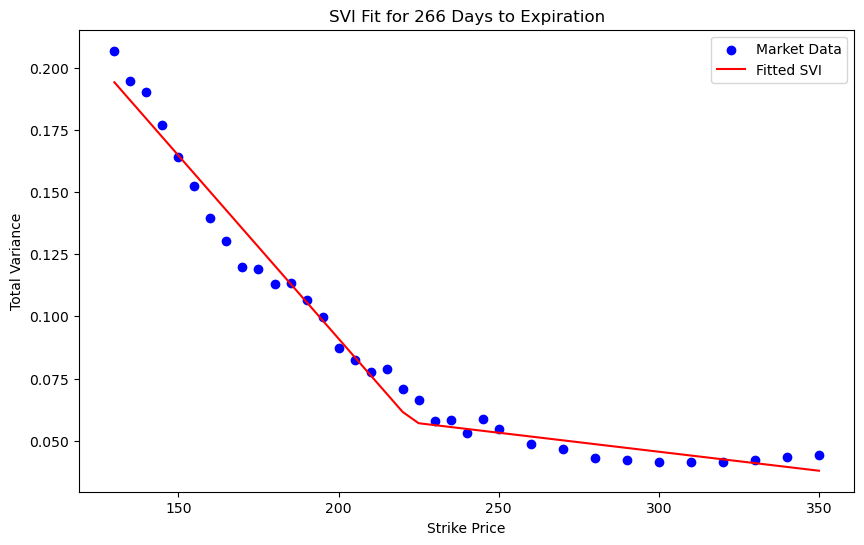

In [27]:
import matplotlib.pyplot as plt

# Calculate fitted total variance
fitted_total_variance = svi_total_variance(fitted_params, strikes)

# Plot the observed vs fitted total variance
plt.figure(figsize=(10, 6))
plt.scatter(strikes, market_total_variance, label='Market Data', color='blue')
plt.plot(strikes, fitted_total_variance, label='Fitted SVI', color='red')
plt.xlabel('Strike Price')
plt.ylabel('Total Variance')
plt.title(f'SVI Fit for {expiry} Days to Expiration')
plt.legend()
plt.show()
